In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.svm import SVC
from tqdm.notebook import tqdm
import time
from pickle import load, dump
import copy
import multiprocessing

In [3]:
def checkerboard4(num_train, num_test, num_grid_col=4, num_grid_row=4, position=0):
    if num_train%2:
        raise ValueError(f"This method wants to create a balanced dataset but received"
                f"odd num_train={num_train}.")
    if num_test%2:
        raise ValueError(f"This method wants to create a balanced dataset but received"
                f"odd num_test={num_test}.")
    num_total = num_train + num_test
    max_samples = num_grid_row * num_grid_col * 40
    if num_total>max_samples:
        raise ValueError(f"Due to intricate legacy reasons, the number of samples"
                f"may not exceed {max_samples}. Received {num_total}.")
    # creating negative (-1) and positive (+1) samples
    negatives = []
    positives = []
    for i in range(num_grid_col):
        for j in range(num_grid_row):
            data = (np.random.random((40,2))-0.5)
            data[:,0] = (data[:,0]+2*i+1)/(2*num_grid_col)
            data[:,1] = (data[:,1]+2*j+1)/(2*num_grid_row)
            if i%2==j%2:
                negatives.append(data)
            else:
                positives.append(data)
    negative = np.vstack(negatives)
    positive = np.vstack(positives)

    # split the data
    np.random.shuffle(negative)
    np.random.shuffle(positive)

    X_train = np.vstack([negative[:num_train//2], positive[:num_train//2]])
    y_train = np.hstack([-np.ones((num_train//2)), np.ones((num_train//2))])
    X_test = np.vstack([negative[num_train//2:num_total//2], positive[num_train//2:num_total//2]])
    y_test = np.hstack([-np.ones((num_test//2)), np.ones((num_test//2))])

    r0 = [X_train, y_train, X_test, y_test]

    X_train_l = X_train[np.where(X_train[:,0] <= 0.5)]
    y_train_l = y_train[np.where(X_train[:,0] <= 0.5)]
    X_test_l = X_test[np.where(X_test[:,0] <= 0.5)]
    y_test_l = y_test[np.where(X_test[:,0] <= 0.5)]

    r1 = [X_train_l[np.where(X_train_l[:,1] <= 0.5)],y_train_l[np.where(X_train_l[:,1] <= 0.5)],X_test_l[np.where(X_test_l[:,1] <= 0.5)],y_test_l[np.where(X_test_l[:,1] <= 0.5)]]
    r3 = [X_train_l[np.where(X_train_l[:,1] >= 0.5)],y_train_l[np.where(X_train_l[:,1] >= 0.5)],X_test_l[np.where(X_test_l[:,1] >= 0.5)],y_test_l[np.where(X_test_l[:,1] >= 0.5)]]

    X_train_r = X_train[np.where(X_train[:,0] >= 0.5)]
    y_train_r = y_train[np.where(X_train[:,0] >= 0.5)]
    X_test_r = X_test[np.where(X_test[:,0] >= 0.5)]
    y_test_r = y_test[np.where(X_test[:,0] >= 0.5)]

    r2 = [X_train_r[np.where(X_train_r[:,1] <= 0.5)],y_train_r[np.where(X_train_r[:,1] <= 0.5)],X_test_r[np.where(X_test_r[:,1] <= 0.5)],y_test_r[np.where(X_test_r[:,1] <= 0.5)]]

    r4 = [X_train_r[np.where(X_train_r[:,1] >= 0.5)],y_train_r[np.where(X_train_r[:,1] >= 0.5)],X_test_r[np.where(X_test_r[:,1] >= 0.5)],y_test_r[np.where(X_test_r[:,1] >= 0.5)]]

    return r0, r1, r2, r3, r4

In [4]:
np.random.seed(43) # Seed, 43 was used for the paper results

num_train = 60 # Number of training datapoints
num_test = 60 # Number of test datapoints

xlims = [0, 1]
ylims = [0, 1]

In [5]:
r0, r1, r2, r3, r4 = checkerboard4(num_train, num_test, num_grid_row=4, num_grid_col=4,position=4)
r = [r0, r1, r2, r3, r4]

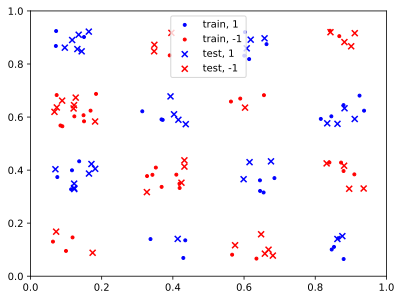

In [6]:
X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

In [7]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding Ansatz.
    Args:
        x (ndarray): Data to be embedded.
        params (ndarray): Trainable circuit parameters.
        wires (qml.Wires): Qubits to act on.
        i0 (int): Wire on which the first embedding rotation gate acts.
        inc (int): Increment between wires on which the embedding rotation gates act.
    Comments:
        Note that this circuit iterates cyclically over the feature vector to be embedded.
    """
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding Ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

def prediction_accuracy(y_predicted, y_target):
    return 1 - np.count_nonzero(y_predicted - y_target) / len(y_target)

def get_random_params(num_wires, num_layers):
    return np.random.uniform(0, 2*np.pi, (num_layers, 2, num_wires))

def target_alignment(X,Y,kernel,assume_normalized_kernel=False,rescale_class_labels=True):
    """Kernel-target alignment between kernel and labels."""
    K = qml.kernels.square_kernel_matrix(X,kernel,assume_normalized_kernel=assume_normalized_kernel)

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [8]:
def node_train(it, para, r, r0, pipes, num_wires = 5, num_epochs = 1000):
    paral = list()
    astr = []
    aste = []
    awte = []

    dev = qml.device("default.qubit", wires=num_wires)
    wires = list(range(num_wires))
    @qml.qnode(dev, diff_method="backprop")
    def kernel(x1, x2, params):
        ansatz(x1, params, wires)
        qml.adjoint(ansatz)(x2, params, wires)
        return qml.expval(qml.Projector([0]*num_wires, wires=wires))
    X_train, y_train, X_test, y_test = tuple(r)
    X_train0, y_train0, X_test0, y_test0 = tuple(r0)
    training_alignment = []
    mapped_kernel = lambda X1, X2: kernel(X1, X2, para)

    paral.append(para)
    mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
    svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
    trained_train_predict = svm_trained_kernel.predict(X_train)
    trained_test_predict = svm_trained_kernel.predict(X_test)
    trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
    print("with kernel training accuracy on self_train", trained_train_accuracy)
    trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
    print("with kernel training accuracy on self_test", trained_test_accuracy)
    astr.append(trained_train_accuracy)
    aste.append(trained_test_accuracy)
    trained_test_predict = svm_trained_kernel.predict(X_test0)
    trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test0)
    awte.append(trained_test_accuracy)
    print("with kernel training accuracy on whole_test", trained_test_accuracy)

    alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
    training_alignment.append(alignment)
    print('Node '+str(it)+": Step 0 - Alignment on train = {:.3f}".format(alignment))
    opt = qml.GradientDescentOptimizer(0.2)
    num = len(pipes)
    for j in range(num):
        pipes[j].send(para)
    for i in tqdm(range(num_epochs)):
        # start = time.time()
        subset = np.random.choice(list(range(len(X_train))), 4)
        mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
        # grad, out = opt.compute_grad(mapped_neg_alignment, tuple([params]), {})
        # new_args = opt.apply_grad(grad, tuple([params]))
        # if len(new_args) == 1:
        #     params = new_args[0]
        for j in range(num):
            para = para + pipes[j].recv()
        para = para/(num+1)
        para = opt.step(mapped_neg_alignment, para)
        for j in range(num):
            pipes[j].send(para)
        # end = time.time()
        # print (str(end-start))
        if (i+1) % 50 == 0:
            mapped_kernel = lambda X1, X2: kernel(X1, X2, para)

            paral.append(params)
            mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
            svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
            trained_train_predict = svm_trained_kernel.predict(X_train)
            trained_test_predict = svm_trained_kernel.predict(X_test)
            trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
            trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
            astr.append(trained_train_accuracy)
            print("with kernel training accuracy on self_train", trained_train_accuracy)
            aste.append(trained_test_accuracy)
            print("with kernel training accuracy on self_test", trained_test_accuracy)
            trained_test_predict = svm_trained_kernel.predict(X_test0)
            trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test0)
            awte.append(trained_test_accuracy)
            print("with kernel training accuracy on whole_test", trained_test_accuracy)

            alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
            training_alignment.append(alignment)
            print('Node '+str(it)+": Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
    trained_params = para.copy()
    with open('p_r'+str(it)+'_tra_d_0.2.pickle', 'wb') as f:
        dump(trained_params, f)
    x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
    plt.plot(x,training_alignment)
    plt.title("Training Result of Node {}".format(it))
    return trained_params

In [13]:
node_num = 4
par_l = list()
for i in range(node_num):
    with open('p_r'+str(i+1)+'_ini.pickle', 'rb') as f:
        par_l.append(load(f))

FileNotFoundError: [Errno 2] No such file or directory: 'p_r2_ini.pickle'

In [12]:
conn121, conn122 = multiprocessing.Pipe()
conn231, conn232 = multiprocessing.Pipe()
conn341, conn342 = multiprocessing.Pipe()
conn141, conn142 = multiprocessing.Pipe()
c1 = [conn121, conn142]
c2 = [conn122, conn231]
c3 = [conn232, conn341]
c4 = [conn342, conn141]
c = [c1, c2, c3, c4]

In [ ]:
nps = list()
for i in range(node_num):
    nps.append(multiprocessing.Process(target=node_train, args=(i+1, par_l[i], r[i+1], r[0], c[i],)))
for i in range(node_num):
    nps[i].start()
for i in range(node_num):
    nps[i].join()
print('Done!')

In [10]:
par_l = list()
for i in range(node_num):
    with open('p_r'+str(i+1)+'_tra_d_0.2.pickle', 'rb') as f:
        par_l.append(load(f))
for i in range(node_num):
    print(par_l[i])

FileNotFoundError: [Errno 2] No such file or directory: 'p_r1_tra_d_0.2.pickle'

In [20]:
trained_params = par_l[1]
X_train, y_train, X_test, y_test = tuple(r0)
num_wires = 5
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

with kernel training accuracy on test 0.6833333333333333


KeyboardInterrupt: 